In [1]:
import os, io, random
import pandas as pd
from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision import transforms
import torch, gc
torch.backends.cudnn.benchmark = True
import torch.nn as nn
import torchvision.models as models
import wandb
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
from torch.cuda.amp import autocast, GradScaler
from collections import Counter
import timm
from ultralytics import YOLO

In [2]:
class LightDegradationPair:
    def __init__(self, resize=(256, 256)):
        self.resize = resize

    def __call__(self, crop_img):
        # Sample shared augmentation parameters
        blur_radius = random.uniform(0.5, 1.5) if random.random() < 0.3 else None
        brightness_factor = random.uniform(0.8, 1.2) if random.random() < 0.1 else None
        contrast_factor = random.uniform(0.8, 1.2) if random.random() < 0.1 else None
        jpeg_quality = random.randint(40, 70) if random.random() < 0.3 else None

        # Apply all to both images
        def degrade(img):
            if blur_radius:
                img = img.filter(ImageFilter.GaussianBlur(blur_radius))
            if brightness_factor:
                img = F.adjust_brightness(img, brightness_factor)
            if contrast_factor:
                img = F.adjust_contrast(img, contrast_factor)
            if jpeg_quality:
                buffer = io.BytesIO()
                img.save(buffer, format='JPEG', quality=jpeg_quality)
                buffer.seek(0)
                img = Image.open(buffer).convert('RGB')
            return transforms.Resize(self.resize)(img)

        crop_img = degrade(crop_img)

        return transforms.ToTensor()(crop_img)


In [3]:
class FashionDataset(Dataset):
    def __init__(self, csv_path, data_root, split='train', transform_pair=None, label_columns=None):
        self.data_root = data_root
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['set'] == split].reset_index(drop=True)
        self.transform_pair = transform_pair
        self.label_columns = label_columns or [
            'gender', 'Clothing_type', 'usage', 'mergedColor',
            'selected_fabric', 'selected_pattern', 'pos'
        ]
        self.label_vocab = {col: {val: i for i, val in enumerate(self.df[col].dropna().unique())} for col in self.label_columns}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        base_name = os.path.splitext(row['name'])[0]

        # Load images
        crop_path = os.path.join(self.data_root, f"{row['set']}_crop", base_name + "_crop.jpg")
        #whole_path = os.path.join(self.data_root, f"{row['set']}_whole", base_name + ".jpg")
        crop_img = Image.open(crop_path).convert('RGB')
        #whole_img = Image.open(whole_path).convert('RGB')

        # Augment both together
        if self.transform_pair:
            crop_img = self.transform_pair(crop_img)

        # Prepare label dict
        labels = {}
        for col in self.label_columns:
            val = row[col]
            labels[col] = self.label_vocab[col].get(val, -1) if pd.notna(val) else -1

        # Add pred_label as an additional input
        pred_label = row['pred_label'] if 'pred_label' in row and pd.notna(row['pred_label']) else None
        return {
            'crop': crop_img,
            'labels': labels,
            'origin': torch.tensor(row['origin']),
            'pred_label': pred_label
        }

In [4]:
# Paired augmentation instance
transform_pair = LightDegradationPair(resize=(256, 256))

# Datasets
train_dataset = FashionDataset(
    csv_path='classification_dataset/labels.csv',
    data_root='classification_dataset',
    split='train',
    transform_pair=transform_pair
)

val_dataset = FashionDataset(
    csv_path='classification_dataset/labels.csv',
    data_root='classification_dataset',
    split='val',
    transform_pair=LightDegradationPair(resize=(256, 256))  # or use no augmentations here
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)


In [5]:
class DualResNetMultiTask(nn.Module):
    def __init__(self, num_classes_dict, embed_dim=1024):
        super().__init__()
        resnet = models.resnet101()
        backbone_new = nn.Sequential(*list(resnet.children())[:-1])
        ckpt = torch.load('model_selfSup_resnet101_hidden512_nogreyAugment.pth')
        backbone_new.load_state_dict(ckpt["resnet101_parameters"])
        self.encoder = backbone_new

        # Freeze encoder
        for param in self.encoder.parameters():
            param.requires_grad = True # Try with slow learning to the encoder

        self.embedding_dim = resnet.fc.in_features
        # +1 for pred_label input
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_dim + 1, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.BatchNorm1d(embed_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Linear(embed_dim // 2, embed_dim // 2),
            nn.BatchNorm1d(embed_dim // 2),
            nn.LeakyReLU(0.1),
        )

        self.heads = nn.ModuleDict({
            name: nn.Linear(embed_dim // 2, num_classes)
            for name, num_classes in num_classes_dict.items()
        })

    def encode(self, crop, pred_label):
        crop_feat = self.encoder(crop).squeeze(-1).squeeze(-1)
        # pred_label: shape (batch,)
        pred_label = pred_label.float().unsqueeze(1)
        fused = torch.cat([crop_feat, pred_label], dim=1)
        return self.fc(fused)

    def forward(self, crop, pred_label):
        emb = self.encode(crop, pred_label)
        return {task: head(emb) for task, head in self.heads.items()}


In [6]:
'''def compute_class_weights(dataset, task_name, num_classes):
    targets = [sample['labels'][task_name] for sample in dataset if sample['labels'][task_name] != -1]
    count = Counter(targets)
    total = sum(count.values())
    weights = [1.0 - (count.get(i, 0) / total) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)'''

"def compute_class_weights(dataset, task_name, num_classes):\n    targets = [sample['labels'][task_name] for sample in dataset if sample['labels'][task_name] != -1]\n    count = Counter(targets)\n    total = sum(count.values())\n    weights = [1.0 - (count.get(i, 0) / total) for i in range(num_classes)]\n    return torch.tensor(weights, dtype=torch.float)"

In [7]:
'''def masked_loss(logits, targets, ignore_index=-1):
    mask = targets != ignore_index
    if mask.sum() == 0:
        return 0.0
    return nn.CrossEntropyLoss(label_smoothing = 0.1)(logits[mask], targets[mask])
'''
def masked_loss(logits, targets, task=None, class_weights=None, ignore_index=-1):
    mask = targets != ignore_index
    if mask.sum() == 0:
        return torch.tensor(0.0, device=logits.device)
    
    weights = class_weights[task] if class_weights and task in class_weights else None
    loss_fn = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

    return loss_fn(logits[mask], targets[mask])

'''def compute_accuracy(logits, targets):
    mask = targets != -1
    if mask.sum() == 0:
        return 0.0
    preds = torch.argmax(logits[mask], dim=1)
    return (preds == targets[mask]).float().mean().item()
'''

'def compute_accuracy(logits, targets):\n    mask = targets != -1\n    if mask.sum() == 0:\n        return 0.0\n    preds = torch.argmax(logits[mask], dim=1)\n    return (preds == targets[mask]).float().mean().item()\n'

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target, task=None, class_weights=None, ignore_index=-1):
        mask = target != ignore_index
        if mask.sum() == 0:
            return torch.tensor(0.0, device=input.device)

        input = input[mask]
        target = target[mask]
        weight = class_weights[task] if class_weights and task in class_weights else None

        ce_loss = torch.nn.functional.cross_entropy(input, target, weight=weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [9]:
wandb.login()
wandb.init(project="visecomp-1input--multifeature-classifier", name="single-image+pred_label-resnet101_customweights_nogrey", notes = 'custom weights resnet101, coming from model without gray scale, maybe colors are not well encoded')


wandb: Currently logged in as: mattia-roccatello (my_wandbteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [10]:
os.makedirs("Classifier_checkpoints/v3/weights", exist_ok=True)
os.makedirs("Classifier_checkpoints/v3/model", exist_ok=True)

os.makedirs("Classifier_checkpoints/autosaved_v3/weights", exist_ok=True)
os.makedirs("Classifier_checkpoints/autosaved_v3/model", exist_ok=True)

In [11]:
from collections import defaultdict, Counter
import torch

def compute_all_class_weights(dataset, num_classes_dict):
    task_counters = {task: Counter() for task in num_classes_dict}
    total_counts = {task: 0 for task in num_classes_dict}

    for sample in tqdm(dataset, desc="Computing class weights"):
        labels = sample['labels']
        for task in num_classes_dict:
            label = labels.get(task, -1)
            if label != -1:
                task_counters[task][label] += 1
                total_counts[task] += 1

    class_weights = {}
    for task, counter in task_counters.items():
        weights = []
        total = total_counts[task]
        for i in range(num_classes_dict[task]):
            count = counter.get(i, 1)
            weights.append(total / (count * num_classes_dict[task]))
        class_weights[task] = torch.tensor(weights, dtype=torch.float)

    return class_weights


In [12]:
num_classes_dict = {
    "gender": 2,
    "Clothing_type": 32,
    "usage": 4,
    "mergedColor": 13,
    "selected_fabric": 7,
    "selected_pattern": 7,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.exists("Classifier_checkpoints/class_weights.pth"):
    class_weights = torch.load("Classifier_checkpoints/class_weights.pth")
    class_weights = {k: v.to(device) for k, v in class_weights.items()}
else:
    class_weights = compute_all_class_weights(train_dataset, num_classes_dict)
    torch.save(class_weights, "Classifier_checkpoints/class_weights.pth")
    class_weights = {k: v.to(device) for k, v in class_weights.items()}

'''loss_fn = {
    task: FocalLoss(gamma=2.0, weight=class_weights[task])
    for task in num_classes_dict
}'''

focal_loss_fn = FocalLoss(gamma=2.0, reduction='mean')
use_focal_tasks = ['Clothing_type', 'mergedColor', 'selected_fabric', 'selected_pattern']



In [13]:
from torch.amp import autocast, GradScaler

num_epochs = 20

model = DualResNetMultiTask(num_classes_dict, embed_dim=1024).to(device)
optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters(), 'lr': 5e-5},
    {'params': model.fc.parameters(), 'lr': 1e-4},
    {'params': model.heads.parameters(), 'lr': 1e-4},
], weight_decay=5e-4)

best_val_score = 0.0
best_model_path = "Classifier_checkpoints/autosaved_v3/model/best_model.pth"
best_weights_path = "Classifier_checkpoints/autosaved_v3/weights/best_weights.pth"
confusion_matrix_path = "Classifier_checkpoints/autosaved_v3/confusion_matrices"
scaler = GradScaler()

print(f'Starting Training for {num_epochs} epochs')

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    total_loss = 0
    task_losses = {k: 0.0 for k in num_classes_dict}
    task_correct = {k: 0 for k in num_classes_dict}
    task_total = {k: 0 for k in num_classes_dict}

    print(f'Epoch: {epoch} ------ TRAINING')
    for batch in tqdm(train_loader):
        crop = batch['crop'].to(device)
        pred_label = batch['pred_label'].to(device)  # Add this line
        labels = batch['labels']
        origin = batch.get('origin', torch.zeros_like(crop[:, 0, 0, 0]))  # 0=FP, 1=DF

        optimizer.zero_grad()

        with autocast(device_type=device.type):
            # Pass both crop and pred_label to the model
            outputs = model(crop, pred_label)
            loss = 0

            for task in outputs:
                if task in ['usage', 'mergedColor', 'selected_fabric', 'selected_pattern']:
                    mask = (origin == 0) if task in ['usage', 'mergedColor'] else (origin == 1)
                    if mask.sum() == 0: continue
                    logits = outputs[task][mask]
                    targets = torch.tensor([labels[task][i] for i in mask.nonzero(as_tuple=True)[0]]).to(device)
                else:
                    logits = outputs[task]
                    targets = labels[task].to(device)

                use_focal_loss = task in use_focal_tasks

                if use_focal_loss:
                    task_loss = focal_loss_fn(logits, targets, task=task, class_weights=class_weights)
                else:
                    task_loss = masked_loss(logits, targets, task=task, class_weights=class_weights)
                    
                preds = torch.argmax(logits, dim=1)
                correct = (preds == targets).sum().item()
                total = targets.numel()
                task_correct[task] += correct
                task_total[task] += total
                task_losses[task] += task_loss.item()

                loss += task_loss

        # Scale and backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    task_accs = {
        task: task_correct[task] / task_total[task] if task_total[task] > 0 else 0.0
        for task in task_correct
    }

    # Log training metrics
    wandb.log({"epoch": epoch, "train_total_loss": total_loss})
    for task in task_losses:
        wandb.log({
            f"train_{task}_loss": task_losses[task],
            f"train_{task}_acc": task_accs[task]
        })

    print(f"Epoch {epoch} Train Loss: {total_loss:.4f}")
    for task in task_losses:
        print({
            f"train_{task}_loss": task_losses[task],
            f"train_{task}_acc": task_accs[task]
        })

    # --- VALIDATION ---
    model.eval()
    val_preds = {k: [] for k in num_classes_dict}
    val_targets = {k: [] for k in num_classes_dict}

    val_losses = {k: 0.0 for k in num_classes_dict}
    val_counts = {k: 0 for k in num_classes_dict}

    print(f'Epoch: {epoch} ------ VALIDATION')
    with torch.no_grad(), autocast(device_type=device.type):
        for batch in tqdm(val_loader):
            crop = batch['crop'].to(device)
            pred_label = batch['pred_label'].to(device)  # Add this line
            labels = batch['labels']
            origin = batch.get('origin', torch.zeros_like(crop[:, 0, 0, 0]))  # 0=FP, 1=DF

            # Pass both crop and pred_label to the model
            outputs = model(crop, pred_label)

            for task in outputs:
                if task in ['usage', 'mergedColor', 'selected_fabric', 'selected_pattern']:
                    mask = (origin == 0) if task in ['usage', 'mergedColor'] else (origin == 1)
                    if mask.sum() == 0: continue
                    logits = outputs[task][mask]
                    targets = torch.tensor([labels[task][i] for i in mask.nonzero(as_tuple=True)[0]]).to(device)
                else:
                    logits = outputs[task]
                    targets = labels[task].to(device)

                preds = torch.argmax(logits, dim=1)

                use_focal_loss = task in use_focal_tasks
                if use_focal_loss:
                    val_loss = focal_loss_fn(logits, targets, task=task, class_weights=class_weights)
                else:
                    val_loss = masked_loss(logits, targets, task=task, class_weights=class_weights)

                val_losses[task] += val_loss.item()
                val_counts[task] += 1

                val_preds[task].append(preds.detach().cpu())
                val_targets[task].append(targets.detach().cpu())

    accuracies = []
    # Compute metrics
    for task in val_preds:
        preds = torch.cat(val_preds[task])
        targets = torch.cat(val_targets[task])

        mask = targets != -1
        if mask.sum() == 0: continue
        
        y_pred = preds[mask].cpu().numpy()
        y_true = targets[mask].cpu().numpy()

        if len(set(y_true)) <= 1:
            continue

        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        acc = accuracy_score(y_true, y_pred)
        avg_loss = val_losses[task]/val_counts[task]

        wandb.log({
            f"val_{task}_precision": prec,
            f"val_{task}_recall": rec,
            f"val_{task}_accuracy": acc,
            f"val_{task}_loss": avg_loss
        })
        
        print(f"Val [{task}]: Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | Loss={avg_loss:.3f}")
        accuracies.append(acc)

    avg_val_acc = sum(accuracies) / len(accuracies) if accuracies else 0.0
    wandb.log({"val_avg_accuracy": avg_val_acc})

    if avg_val_acc > best_val_score:
        best_val_score = avg_val_acc
        torch.save(model.state_dict(), best_weights_path)
        torch.save(model, best_model_path)
        print(f"✅ New best model saved with avg accuracy {avg_val_acc:.4f}")

        confusion_dir = confusion_matrix_path
        os.makedirs(confusion_dir, exist_ok=True)

        for task in outputs:
            preds = torch.cat(val_preds[task]).cpu()
            targets = torch.cat(val_targets[task]).cpu()

            if preds.numel() == 0 or targets.numel() == 0:
                continue

            cm = confusion_matrix(targets, preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_dataset.label_vocab[task].keys()))
            
            fig, ax = plt.subplots(figsize=(8, 8))
            disp.plot(ax=ax, xticks_rotation='vertical', colorbar=False)
            plt.title(f'Confusion Matrix - {task}')
            plt.tight_layout()
            
            fig_path = os.path.join(confusion_dir, f"{task}_confusion_matrix.png")
            plt.savefig(fig_path)
            plt.close()
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    scheduler.step(avg_val_acc)
    torch.cuda.empty_cache()
    gc.collect()


Starting Training for 20 epochs
Epoch: 0 ------ TRAINING


100%|██████████| 3069/3069 [04:48<00:00, 10.64it/s]


Epoch 0 Train Loss: 26416.2111
{'train_gender_loss': 1662.0748544037342, 'train_gender_acc': 0.778775659824047}
{'train_Clothing_type_loss': 6988.1492760032415, 'train_Clothing_type_acc': 0.10663082437275985}
{'train_usage_loss': 4324.423326790333, 'train_usage_acc': 0.43774736540937487}
{'train_mergedColor_loss': 4454.305143773556, 'train_mergedColor_acc': 0.3105240570311382}
{'train_selected_fabric_loss': 4668.845627363771, 'train_selected_fabric_acc': 0.07165961682010451}
{'train_selected_pattern_loss': 4318.412941992283, 'train_selected_pattern_acc': 0.0804748871432126}
Epoch: 0 ------ VALIDATION


100%|██████████| 768/768 [00:45<00:00, 16.88it/s]


Val [gender]: Acc=0.758 | Prec=0.747 | Rec=0.682 | Loss=0.625
Val [Clothing_type]: Acc=0.032 | Prec=0.060 | Rec=0.067 | Loss=15.849
Val [usage]: Acc=0.408 | Prec=0.338 | Rec=0.396 | Loss=1.457
Val [mergedColor]: Acc=0.065 | Prec=0.129 | Rec=0.077 | Loss=3.296
Val [selected_fabric]: Acc=0.158 | Prec=0.147 | Rec=0.251 | Loss=3.224
Val [selected_pattern]: Acc=0.037 | Prec=0.201 | Rec=0.093 | Loss=2.174
✅ New best model saved with avg accuracy 0.2430
Epoch: 1 ------ TRAINING


100%|██████████| 3069/3069 [04:48<00:00, 10.64it/s]


Epoch 1 Train Loss: 21929.6603
{'train_gender_loss': 1477.0170873105526, 'train_gender_acc': 0.8264907135874878}
{'train_Clothing_type_loss': 5396.908619634807, 'train_Clothing_type_acc': 0.16558732486151842}
{'train_usage_loss': 3937.0926052629948, 'train_usage_acc': 0.5589146917171331}
{'train_mergedColor_loss': 3362.7003253288567, 'train_mergedColor_acc': 0.3809546516618187}
{'train_selected_fabric_loss': 4023.7190196849406, 'train_selected_fabric_acc': 0.07940852379767532}
{'train_selected_pattern_loss': 3732.222713254392, 'train_selected_pattern_acc': 0.1253332385454804}
Epoch: 1 ------ VALIDATION


100%|██████████| 768/768 [00:45<00:00, 16.91it/s]


Val [gender]: Acc=0.861 | Prec=0.843 | Rec=0.873 | Loss=0.434
Val [Clothing_type]: Acc=0.058 | Prec=0.082 | Rec=0.069 | Loss=17.909
Val [usage]: Acc=0.491 | Prec=0.410 | Rec=0.405 | Loss=1.623
Val [mergedColor]: Acc=0.108 | Prec=0.105 | Rec=0.111 | Loss=4.082
Val [selected_fabric]: Acc=0.116 | Prec=0.146 | Rec=0.238 | Loss=3.577
Val [selected_pattern]: Acc=0.063 | Prec=0.203 | Rec=0.157 | Loss=2.293
✅ New best model saved with avg accuracy 0.2830
Epoch: 2 ------ TRAINING


100%|██████████| 3069/3069 [04:47<00:00, 10.68it/s]


Epoch 2 Train Loss: 19639.9943
{'train_gender_loss': 1377.6459948420525, 'train_gender_acc': 0.8549405343760182}
{'train_Clothing_type_loss': 4659.990653380752, 'train_Clothing_type_acc': 0.19802867383512546}
{'train_usage_loss': 3696.0733194947243, 'train_usage_acc': 0.6027847980544562}
{'train_mergedColor_loss': 3002.2883395440876, 'train_mergedColor_acc': 0.43154832864431836}
{'train_selected_fabric_loss': 3577.803707141429, 'train_selected_fabric_acc': 0.09842533679308997}
{'train_selected_pattern_loss': 3326.1923330053687, 'train_selected_pattern_acc': 0.1672413180250951}
Epoch: 2 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.56it/s]


Val [gender]: Acc=0.878 | Prec=0.860 | Rec=0.872 | Loss=0.435
Val [Clothing_type]: Acc=0.038 | Prec=0.054 | Rec=0.070 | Loss=19.153
Val [usage]: Acc=0.444 | Prec=0.390 | Rec=0.383 | Loss=1.743
Val [mergedColor]: Acc=0.099 | Prec=0.107 | Rec=0.095 | Loss=4.317
Val [selected_fabric]: Acc=0.228 | Prec=0.165 | Rec=0.312 | Loss=3.002
Val [selected_pattern]: Acc=0.111 | Prec=0.206 | Rec=0.192 | Loss=2.210
✅ New best model saved with avg accuracy 0.2996
Epoch: 3 ------ TRAINING


100%|██████████| 3069/3069 [04:47<00:00, 10.67it/s]


Epoch 3 Train Loss: 18529.2744
{'train_gender_loss': 1345.5206758081913, 'train_gender_acc': 0.8630457803844901}
{'train_Clothing_type_loss': 4178.370210930705, 'train_Clothing_type_acc': 0.21087895079830563}
{'train_usage_loss': 3604.873291552067, 'train_usage_acc': 0.6247675361213104}
{'train_mergedColor_loss': 2867.5156213138252, 'train_mergedColor_acc': 0.43908254255877166}
{'train_selected_fabric_loss': 3420.9093675501645, 'train_selected_fabric_acc': 0.10226424483702413}
{'train_selected_pattern_loss': 3112.0851738490164, 'train_selected_pattern_acc': 0.2041374897806846}
Epoch: 3 ------ VALIDATION


100%|██████████| 768/768 [00:47<00:00, 16.32it/s]


Val [gender]: Acc=0.905 | Prec=0.891 | Rec=0.900 | Loss=0.395
Val [Clothing_type]: Acc=0.049 | Prec=0.069 | Rec=0.082 | Loss=21.930
Val [usage]: Acc=0.505 | Prec=0.381 | Rec=0.407 | Loss=1.763
Val [mergedColor]: Acc=0.096 | Prec=0.076 | Rec=0.089 | Loss=4.930
Val [selected_fabric]: Acc=0.311 | Prec=0.165 | Rec=0.315 | Loss=2.915
Val [selected_pattern]: Acc=0.127 | Prec=0.233 | Rec=0.189 | Loss=2.330
✅ New best model saved with avg accuracy 0.3322
Epoch: 4 ------ TRAINING


100%|██████████| 3069/3069 [04:46<00:00, 10.72it/s]


Epoch 4 Train Loss: 17421.0243
{'train_gender_loss': 1271.2863094359636, 'train_gender_acc': 0.8797246660149886}
{'train_Clothing_type_loss': 3686.415331669152, 'train_Clothing_type_acc': 0.2349095796676442}
{'train_usage_loss': 3488.8656115829945, 'train_usage_acc': 0.6558104048447857}
{'train_mergedColor_loss': 2758.415128070861, 'train_mergedColor_acc': 0.46712126269610416}
{'train_selected_fabric_loss': 3221.0028434582055, 'train_selected_fabric_acc': 0.11253687839903316}
{'train_selected_pattern_loss': 2995.039071138948, 'train_selected_pattern_acc': 0.20737212526214766}
Epoch: 4 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.52it/s]


Val [gender]: Acc=0.918 | Prec=0.904 | Rec=0.917 | Loss=0.380
Val [Clothing_type]: Acc=0.026 | Prec=0.060 | Rec=0.066 | Loss=22.978
Val [usage]: Acc=0.544 | Prec=0.411 | Rec=0.410 | Loss=1.876
Val [mergedColor]: Acc=0.096 | Prec=0.108 | Rec=0.092 | Loss=4.600
Val [selected_fabric]: Acc=0.250 | Prec=0.163 | Rec=0.283 | Loss=3.173
Val [selected_pattern]: Acc=0.132 | Prec=0.233 | Rec=0.200 | Loss=2.370
Epoch: 5 ------ TRAINING


100%|██████████| 3069/3069 [04:48<00:00, 10.64it/s]


Epoch 5 Train Loss: 16537.7874
{'train_gender_loss': 1228.5995736420155, 'train_gender_acc': 0.8895812968393614}
{'train_Clothing_type_loss': 3390.632913045585, 'train_Clothing_type_acc': 0.2412227109807755}
{'train_usage_loss': 3421.221069186926, 'train_usage_acc': 0.6729292832959801}
{'train_mergedColor_loss': 2618.172170750797, 'train_mergedColor_acc': 0.4883410423918745}
{'train_selected_fabric_loss': 2992.186368275434, 'train_selected_fabric_acc': 0.11559378665624}
{'train_selected_pattern_loss': 2886.9752918183804, 'train_selected_pattern_acc': 0.21348594177656133}
Epoch: 5 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.60it/s]


Val [gender]: Acc=0.892 | Prec=0.876 | Rec=0.885 | Loss=0.423
Val [Clothing_type]: Acc=0.024 | Prec=0.039 | Rec=0.066 | Loss=24.115
Val [usage]: Acc=0.475 | Prec=0.399 | Rec=0.393 | Loss=1.738
Val [mergedColor]: Acc=0.115 | Prec=0.097 | Rec=0.111 | Loss=4.690
Val [selected_fabric]: Acc=0.304 | Prec=0.165 | Rec=0.300 | Loss=3.246
Val [selected_pattern]: Acc=0.105 | Prec=0.219 | Rec=0.160 | Loss=2.398
Epoch: 6 ------ TRAINING


100%|██████████| 3069/3069 [04:47<00:00, 10.68it/s]


Epoch 6 Train Loss: 16093.6657
{'train_gender_loss': 1205.7422550171614, 'train_gender_acc': 0.8973403388725969}
{'train_Clothing_type_loss': 3153.7788302972913, 'train_Clothing_type_acc': 0.247148908439231}
{'train_usage_loss': 3371.6147349476814, 'train_usage_acc': 0.6888560392923561}
{'train_mergedColor_loss': 2568.659133674577, 'train_mergedColor_acc': 0.48929474035572934}
{'train_selected_fabric_loss': 3000.849700976163, 'train_selected_fabric_acc': 0.12302278463014965}
{'train_selected_pattern_loss': 2793.0210459530354, 'train_selected_pattern_acc': 0.22862830128319056}
Epoch: 6 ------ VALIDATION


100%|██████████| 768/768 [00:47<00:00, 16.21it/s]


Val [gender]: Acc=0.905 | Prec=0.888 | Rec=0.914 | Loss=0.376
Val [Clothing_type]: Acc=0.028 | Prec=0.064 | Rec=0.060 | Loss=26.194
Val [usage]: Acc=0.550 | Prec=0.394 | Rec=0.422 | Loss=1.845
Val [mergedColor]: Acc=0.090 | Prec=0.107 | Rec=0.091 | Loss=4.593
Val [selected_fabric]: Acc=0.279 | Prec=0.160 | Rec=0.308 | Loss=3.213
Val [selected_pattern]: Acc=0.177 | Prec=0.226 | Rec=0.202 | Loss=2.514
✅ New best model saved with avg accuracy 0.3382
Epoch: 7 ------ TRAINING


100%|██████████| 3069/3069 [04:46<00:00, 10.71it/s]


Epoch 7 Train Loss: 15314.7297
{'train_gender_loss': 1178.0140068382025, 'train_gender_acc': 0.9025333985011404}
{'train_Clothing_type_loss': 2960.6719387993217, 'train_Clothing_type_acc': 0.2613432714239166}
{'train_usage_loss': 3331.5474818348885, 'train_usage_acc': 0.7003957846549997}
{'train_mergedColor_loss': 2451.737422691658, 'train_mergedColor_acc': 0.5047923322683706}
{'train_selected_fabric_loss': 2699.3829942326993, 'train_selected_fabric_acc': 0.13116269150108414}
{'train_selected_pattern_loss': 2693.3758646762, 'train_selected_pattern_acc': 0.23314257277929834}
Epoch: 7 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.37it/s]


Val [gender]: Acc=0.932 | Prec=0.920 | Rec=0.930 | Loss=0.357
Val [Clothing_type]: Acc=0.041 | Prec=0.072 | Rec=0.076 | Loss=27.813
Val [usage]: Acc=0.557 | Prec=0.417 | Rec=0.429 | Loss=1.752
Val [mergedColor]: Acc=0.101 | Prec=0.105 | Rec=0.100 | Loss=4.725
Val [selected_fabric]: Acc=0.346 | Prec=0.162 | Rec=0.313 | Loss=3.034
Val [selected_pattern]: Acc=0.196 | Prec=0.222 | Rec=0.208 | Loss=2.364
✅ New best model saved with avg accuracy 0.3622
Epoch: 8 ------ TRAINING


100%|██████████| 3069/3069 [04:45<00:00, 10.74it/s]


Epoch 8 Train Loss: 14831.3533
{'train_gender_loss': 1159.7716717123985, 'train_gender_acc': 0.906708211143695}
{'train_Clothing_type_loss': 2843.2788492143154, 'train_Clothing_type_acc': 0.2640518084066471}
{'train_usage_loss': 3312.1977949738503, 'train_usage_acc': 0.7075485193839112}
{'train_mergedColor_loss': 2363.9642738122493, 'train_mergedColor_acc': 0.5188116923370368}
{'train_selected_fabric_loss': 2487.2030794620514, 'train_selected_fabric_acc': 0.1361745992251093}
{'train_selected_pattern_loss': 2664.9376883022487, 'train_selected_pattern_acc': 0.2411758433156791}
Epoch: 8 ------ VALIDATION


100%|██████████| 768/768 [00:47<00:00, 16.25it/s]


Val [gender]: Acc=0.939 | Prec=0.928 | Rec=0.938 | Loss=0.348
Val [Clothing_type]: Acc=0.039 | Prec=0.078 | Rec=0.081 | Loss=29.033
Val [usage]: Acc=0.564 | Prec=0.419 | Rec=0.413 | Loss=1.921
Val [mergedColor]: Acc=0.111 | Prec=0.116 | Rec=0.108 | Loss=4.603
Val [selected_fabric]: Acc=0.397 | Prec=0.163 | Rec=0.292 | Loss=3.472
Val [selected_pattern]: Acc=0.155 | Prec=0.236 | Rec=0.204 | Loss=2.568
✅ New best model saved with avg accuracy 0.3676
Epoch: 9 ------ TRAINING


100%|██████████| 3069/3069 [04:43<00:00, 10.84it/s]


Epoch 9 Train Loss: 14452.4808
{'train_gender_loss': 1154.2923539727926, 'train_gender_acc': 0.9088261648745519}
{'train_Clothing_type_loss': 2729.4622708410025, 'train_Clothing_type_acc': 0.2671676441837732}
{'train_usage_loss': 3247.567466378212, 'train_usage_acc': 0.7142720900290878}
{'train_mergedColor_loss': 2351.5052418895066, 'train_mergedColor_acc': 0.5219588956177579}
{'train_selected_fabric_loss': 2462.253494905308, 'train_selected_fabric_acc': 0.14083105250062206}
{'train_selected_pattern_loss': 2507.399969510734, 'train_selected_pattern_acc': 0.24565456936693564}
Epoch: 9 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.40it/s]


Val [gender]: Acc=0.892 | Prec=0.876 | Rec=0.885 | Loss=0.411
Val [Clothing_type]: Acc=0.032 | Prec=0.043 | Rec=0.079 | Loss=29.601
Val [usage]: Acc=0.563 | Prec=0.419 | Rec=0.426 | Loss=1.639
Val [mergedColor]: Acc=0.119 | Prec=0.133 | Rec=0.110 | Loss=4.866
Val [selected_fabric]: Acc=0.372 | Prec=0.160 | Rec=0.305 | Loss=3.329
Val [selected_pattern]: Acc=0.088 | Prec=0.217 | Rec=0.173 | Loss=2.749
Epoch: 10 ------ TRAINING


100%|██████████| 3069/3069 [04:45<00:00, 10.75it/s]


Epoch 10 Train Loss: 14105.1068
{'train_gender_loss': 1139.6058055907488, 'train_gender_acc': 0.9111681329423265}
{'train_Clothing_type_loss': 2645.2895933389664, 'train_Clothing_type_acc': 0.2737862495927012}
{'train_usage_loss': 3260.864958435297, 'train_usage_acc': 0.7211387153688427}
{'train_mergedColor_loss': 2296.305319971754, 'train_mergedColor_acc': 0.5247723046111297}
{'train_selected_fabric_loss': 2330.8154579717666, 'train_selected_fabric_acc': 0.1465894145665233}
{'train_selected_pattern_loss': 2432.2256631478667, 'train_selected_pattern_acc': 0.25837983862368036}
Epoch: 10 ------ VALIDATION


100%|██████████| 768/768 [00:45<00:00, 16.71it/s]


Val [gender]: Acc=0.931 | Prec=0.921 | Rec=0.927 | Loss=0.357
Val [Clothing_type]: Acc=0.033 | Prec=0.075 | Rec=0.075 | Loss=28.351
Val [usage]: Acc=0.583 | Prec=0.400 | Rec=0.423 | Loss=1.893
Val [mergedColor]: Acc=0.127 | Prec=0.130 | Rec=0.112 | Loss=5.059
Val [selected_fabric]: Acc=0.323 | Prec=0.160 | Rec=0.308 | Loss=3.748
Val [selected_pattern]: Acc=0.130 | Prec=0.217 | Rec=0.192 | Loss=2.858
Epoch: 11 ------ TRAINING


100%|██████████| 3069/3069 [04:45<00:00, 10.76it/s]


Epoch 11 Train Loss: 13630.9154
{'train_gender_loss': 1127.2540807574987, 'train_gender_acc': 0.9144061583577713}
{'train_Clothing_type_loss': 2505.8051322996616, 'train_Clothing_type_acc': 0.28242098403388727}
{'train_usage_loss': 3200.1287196725607, 'train_usage_acc': 0.7313432835820896}
{'train_mergedColor_loss': 2224.4374514687806, 'train_mergedColor_acc': 0.5330694768966668}
{'train_selected_fabric_loss': 2256.6144103221595, 'train_selected_fabric_acc': 0.14872214125759783}
{'train_selected_pattern_loss': 2316.6756371818483, 'train_selected_pattern_acc': 0.2656666548181851}
Epoch: 11 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.55it/s]


Val [gender]: Acc=0.948 | Prec=0.938 | Rec=0.949 | Loss=0.337
Val [Clothing_type]: Acc=0.030 | Prec=0.069 | Rec=0.070 | Loss=30.897
Val [usage]: Acc=0.582 | Prec=0.426 | Rec=0.416 | Loss=1.952
Val [mergedColor]: Acc=0.108 | Prec=0.117 | Rec=0.107 | Loss=5.115
Val [selected_fabric]: Acc=0.356 | Prec=0.149 | Rec=0.302 | Loss=3.393
Val [selected_pattern]: Acc=0.198 | Prec=0.228 | Rec=0.213 | Loss=3.217
✅ New best model saved with avg accuracy 0.3705
Epoch: 12 ------ TRAINING


100%|██████████| 3069/3069 [04:45<00:00, 10.75it/s]


Epoch 12 Train Loss: 13163.2601
{'train_gender_loss': 1113.3413302600384, 'train_gender_acc': 0.9172165200391007}
{'train_Clothing_type_loss': 2436.6343594640493, 'train_Clothing_type_acc': 0.2910760834147931}
{'train_usage_loss': 3200.0987925827503, 'train_usage_acc': 0.733298364407992}
{'train_mergedColor_loss': 2214.9862247160636, 'train_mergedColor_acc': 0.5383625005960613}
{'train_selected_fabric_loss': 1991.6297974996269, 'train_selected_fabric_acc': 0.15803504780862332}
{'train_selected_pattern_loss': 2206.5695889629424, 'train_selected_pattern_acc': 0.2841858315856823}
Epoch: 12 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.47it/s]


Val [gender]: Acc=0.933 | Prec=0.919 | Rec=0.937 | Loss=0.340
Val [Clothing_type]: Acc=0.036 | Prec=0.072 | Rec=0.067 | Loss=28.439
Val [usage]: Acc=0.611 | Prec=0.412 | Rec=0.431 | Loss=1.907
Val [mergedColor]: Acc=0.105 | Prec=0.105 | Rec=0.104 | Loss=5.100
Val [selected_fabric]: Acc=0.355 | Prec=0.153 | Rec=0.248 | Loss=3.899
Val [selected_pattern]: Acc=0.127 | Prec=0.218 | Rec=0.190 | Loss=3.203
Epoch: 13 ------ TRAINING


100%|██████████| 3069/3069 [04:46<00:00, 10.70it/s]


Epoch 13 Train Loss: 12863.5837
{'train_gender_loss': 1097.0824838876724, 'train_gender_acc': 0.9202508960573477}
{'train_Clothing_type_loss': 2324.8676791805774, 'train_Clothing_type_acc': 0.2963506028022157}
{'train_usage_loss': 3191.0702333450317, 'train_usage_acc': 0.743836726908588}
{'train_mergedColor_loss': 2173.256746872328, 'train_mergedColor_acc': 0.5502360402460541}
{'train_selected_fabric_loss': 1915.4507188536227, 'train_selected_fabric_acc': 0.165321864003128}
{'train_selected_pattern_loss': 2161.8557811696082, 'train_selected_pattern_acc': 0.2789251057476984}
Epoch: 13 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.45it/s]


Val [gender]: Acc=0.946 | Prec=0.936 | Rec=0.946 | Loss=0.330
Val [Clothing_type]: Acc=0.034 | Prec=0.073 | Rec=0.067 | Loss=30.793
Val [usage]: Acc=0.617 | Prec=0.427 | Rec=0.426 | Loss=1.898
Val [mergedColor]: Acc=0.104 | Prec=0.122 | Rec=0.102 | Loss=4.833
Val [selected_fabric]: Acc=0.408 | Prec=0.152 | Rec=0.332 | Loss=3.588
Val [selected_pattern]: Acc=0.160 | Prec=0.226 | Rec=0.197 | Loss=3.050
✅ New best model saved with avg accuracy 0.3784
Epoch: 14 ------ TRAINING


100%|██████████| 3069/3069 [04:46<00:00, 10.73it/s]


Epoch 14 Train Loss: 12536.5902
{'train_gender_loss': 1094.9611922204494, 'train_gender_acc': 0.9210043988269795}
{'train_Clothing_type_loss': 2244.178231202066, 'train_Clothing_type_acc': 0.2976946888237211}
{'train_usage_loss': 3157.400474369526, 'train_usage_acc': 0.7402126746459397}
{'train_mergedColor_loss': 2151.434178329073, 'train_mergedColor_acc': 0.5414143340803967}
{'train_selected_fabric_loss': 1795.8892226535827, 'train_selected_fabric_acc': 0.1651441367788718}
{'train_selected_pattern_loss': 2092.726900741458, 'train_selected_pattern_acc': 0.2834393772438062}
Epoch: 14 ------ VALIDATION


100%|██████████| 768/768 [00:45<00:00, 16.90it/s]


Val [gender]: Acc=0.834 | Prec=0.824 | Rec=0.795 | Loss=0.488
Val [Clothing_type]: Acc=0.019 | Prec=0.072 | Rec=0.054 | Loss=34.992
Val [usage]: Acc=0.448 | Prec=0.454 | Rec=0.448 | Loss=1.627
Val [mergedColor]: Acc=0.100 | Prec=0.128 | Rec=0.099 | Loss=4.504
Val [selected_fabric]: Acc=0.334 | Prec=0.163 | Rec=0.281 | Loss=4.155
Val [selected_pattern]: Acc=0.115 | Prec=0.241 | Rec=0.180 | Loss=3.441
Epoch: 15 ------ TRAINING


100%|██████████| 3069/3069 [04:49<00:00, 10.61it/s]


Epoch 15 Train Loss: 12330.9524
{'train_gender_loss': 1086.6651479452848, 'train_gender_acc': 0.9238758553274682}
{'train_Clothing_type_loss': 2191.2466202005744, 'train_Clothing_type_acc': 0.3034783317041382}
{'train_usage_loss': 3142.570990949869, 'train_usage_acc': 0.7486052167278623}
{'train_mergedColor_loss': 2071.014181663282, 'train_mergedColor_acc': 0.5560535978255686}
{'train_selected_fabric_loss': 1806.7890460472554, 'train_selected_fabric_acc': 0.17189777130060782}
{'train_selected_pattern_loss': 2032.6664455272257, 'train_selected_pattern_acc': 0.29524046493441863}
Epoch: 15 ------ VALIDATION


100%|██████████| 768/768 [00:47<00:00, 16.19it/s]


Val [gender]: Acc=0.946 | Prec=0.933 | Rec=0.949 | Loss=0.321
Val [Clothing_type]: Acc=0.039 | Prec=0.075 | Rec=0.072 | Loss=32.815
Val [usage]: Acc=0.544 | Prec=0.426 | Rec=0.406 | Loss=2.076
Val [mergedColor]: Acc=0.121 | Prec=0.127 | Rec=0.113 | Loss=5.040
Val [selected_fabric]: Acc=0.339 | Prec=0.152 | Rec=0.323 | Loss=4.186
Val [selected_pattern]: Acc=0.156 | Prec=0.226 | Rec=0.195 | Loss=3.058
Epoch: 16 ------ TRAINING


100%|██████████| 3069/3069 [04:53<00:00, 10.45it/s]


Epoch 16 Train Loss: 11869.8390
{'train_gender_loss': 1074.181388631463, 'train_gender_acc': 0.9269102313457153}
{'train_Clothing_type_loss': 2107.205918278545, 'train_Clothing_type_acc': 0.3062886933854676}
{'train_usage_loss': 3158.915682375431, 'train_usage_acc': 0.7510371465356922}
{'train_mergedColor_loss': 2014.1618812915403, 'train_mergedColor_acc': 0.5650183586858042}
{'train_selected_fabric_loss': 1562.7307427227497, 'train_selected_fabric_acc': 0.17452813421959976}
{'train_selected_pattern_loss': 1952.643411193043, 'train_selected_pattern_acc': 0.3011765542245761}
Epoch: 16 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.42it/s]


Val [gender]: Acc=0.818 | Prec=0.808 | Rec=0.773 | Loss=0.509
Val [Clothing_type]: Acc=0.033 | Prec=0.062 | Rec=0.077 | Loss=36.487
Val [usage]: Acc=0.506 | Prec=0.424 | Rec=0.437 | Loss=1.461
Val [mergedColor]: Acc=0.105 | Prec=0.143 | Rec=0.101 | Loss=5.152
Val [selected_fabric]: Acc=0.317 | Prec=0.167 | Rec=0.325 | Loss=4.033
Val [selected_pattern]: Acc=0.135 | Prec=0.223 | Rec=0.162 | Loss=3.567
Epoch: 17 ------ TRAINING


100%|██████████| 3069/3069 [04:53<00:00, 10.47it/s]


Epoch 17 Train Loss: 11642.0269
{'train_gender_loss': 1056.0508732646704, 'train_gender_acc': 0.9320218312153796}
{'train_Clothing_type_loss': 2036.582184586674, 'train_Clothing_type_acc': 0.31575839035516456}
{'train_usage_loss': 3111.9882287085056, 'train_usage_acc': 0.7583329359591817}
{'train_mergedColor_loss': 2052.166111549828, 'train_mergedColor_acc': 0.5637785513327929}
{'train_selected_fabric_loss': 1488.5489914938807, 'train_selected_fabric_acc': 0.17651867913126934}
{'train_selected_pattern_loss': 1896.6904801614583, 'train_selected_pattern_acc': 0.31091600611381653}
Epoch: 17 ------ VALIDATION


100%|██████████| 768/768 [00:47<00:00, 16.10it/s]


Val [gender]: Acc=0.946 | Prec=0.938 | Rec=0.942 | Loss=0.340
Val [Clothing_type]: Acc=0.032 | Prec=0.076 | Rec=0.071 | Loss=32.287
Val [usage]: Acc=0.572 | Prec=0.398 | Rec=0.421 | Loss=1.916
Val [mergedColor]: Acc=0.121 | Prec=0.117 | Rec=0.119 | Loss=4.557
Val [selected_fabric]: Acc=0.356 | Prec=0.160 | Rec=0.333 | Loss=3.906
Val [selected_pattern]: Acc=0.136 | Prec=0.228 | Rec=0.173 | Loss=3.544
Epoch: 18 ------ TRAINING


100%|██████████| 3069/3069 [04:51<00:00, 10.54it/s]


Epoch 18 Train Loss: 11232.5313
{'train_gender_loss': 1054.3406572043896, 'train_gender_acc': 0.9322051156728576}
{'train_Clothing_type_loss': 1945.920434024185, 'train_Clothing_type_acc': 0.3238229064841968}
{'train_usage_loss': 3106.3069229424, 'train_usage_acc': 0.7644842878260455}
{'train_mergedColor_loss': 1978.0485496111214, 'train_mergedColor_acc': 0.5714081350436316}
{'train_selected_fabric_loss': 1295.189193688333, 'train_selected_fabric_acc': 0.18579604023744356}
{'train_selected_pattern_loss': 1852.7254976611584, 'train_selected_pattern_acc': 0.31998009455088333}
Epoch: 18 ------ VALIDATION


100%|██████████| 768/768 [00:47<00:00, 16.31it/s]


Val [gender]: Acc=0.958 | Prec=0.950 | Rec=0.955 | Loss=0.318
Val [Clothing_type]: Acc=0.037 | Prec=0.076 | Rec=0.073 | Loss=33.465
Val [usage]: Acc=0.627 | Prec=0.411 | Rec=0.434 | Loss=1.965
Val [mergedColor]: Acc=0.107 | Prec=0.118 | Rec=0.104 | Loss=5.145
Val [selected_fabric]: Acc=0.413 | Prec=0.157 | Rec=0.299 | Loss=4.104
Val [selected_pattern]: Acc=0.221 | Prec=0.235 | Rec=0.223 | Loss=3.577
✅ New best model saved with avg accuracy 0.3938
Epoch: 19 ------ TRAINING


100%|██████████| 3069/3069 [04:46<00:00, 10.70it/s]


Epoch 19 Train Loss: 10934.4915
{'train_gender_loss': 1048.4797928631306, 'train_gender_acc': 0.9320218312153796}
{'train_Clothing_type_loss': 1881.6345670819283, 'train_Clothing_type_acc': 0.3329871293580971}
{'train_usage_loss': 3096.216134250164, 'train_usage_acc': 0.7668208478374898}
{'train_mergedColor_loss': 1939.8058393755928, 'train_mergedColor_acc': 0.5746507081207382}
{'train_selected_fabric_loss': 1185.8139562755823, 'train_selected_fabric_acc': 0.19247858386947714}
{'train_selected_pattern_loss': 1782.5412293747067, 'train_selected_pattern_acc': 0.32765791063875166}
Epoch: 19 ------ VALIDATION


100%|██████████| 768/768 [00:46<00:00, 16.55it/s]


Val [gender]: Acc=0.956 | Prec=0.947 | Rec=0.957 | Loss=0.315
Val [Clothing_type]: Acc=0.046 | Prec=0.080 | Rec=0.069 | Loss=34.191
Val [usage]: Acc=0.563 | Prec=0.426 | Rec=0.410 | Loss=2.151
Val [mergedColor]: Acc=0.112 | Prec=0.118 | Rec=0.109 | Loss=5.516
Val [selected_fabric]: Acc=0.421 | Prec=0.156 | Rec=0.288 | Loss=4.530
Val [selected_pattern]: Acc=0.206 | Prec=0.219 | Rec=0.210 | Loss=3.675


## Matcher evaluation

In [23]:
# Load the best model
best_model = torch.load("Classifier_checkpoints/autosaved_v3/model/best_model.pth", map_location=device)
best_model.eval()

# Read the labels.csv file with all annotations
labels_df = pd.read_csv('classification_dataset/labels.csv')

labels_df = labels_df[labels_df.origin == 1]
display(labels_df)


Unnamed: 0  origin                                               name  \
26172       26172       1            WOMEN-Dresses-id_00000202-01_3_back.jpg   
26173       26173       1        WOMEN-Tees_Tanks-id_00003941-11_1_front.jpg   
26174       26174       1        WOMEN-Tees_Tanks-id_00002732-06_1_front.jpg   
26175       26175       1        WOMEN-Tees_Tanks-id_00005370-07_1_front.jpg   
26176       26176       1  WOMEN-Sweatshirts_Hoodies-id_00005570-03_1_fro...   
...           ...     ...                                                ...   
61374       61381       1     WOMEN-Blouses_Shirts-id_00002614-01_3_back.jpg   
61375       61382       1         WOMEN-Tees_Tanks-id_00002162-13_2_side.jpg   
61376       61383       1   WOMEN-Tees_Tanks-id_00004662-06_7_additional.jpg   
61377       61384       1     WOMEN-Blouses_Shirts-id_00003620-03_2_side.jpg   
61378       61385       1         MEN-Shirts_Polos-id_00003725-03_2_side.jpg   

      gender Clothing_type usage mergedColor selected_fabric selected_pattern  \
26172  Women       Dresses   NaN         NaN         chiffon       pure_color   
26173  Women          Tops   NaN         NaN          cotton       pure_color   
26174  Women          Tops   NaN         NaN          cotton       pure_color   
26175  Women          Tops   NaN         NaN          cotton       pure_color   
26176  Women   Sweatshirts   NaN         NaN          cotton       pure_color   
...      ...           ...   ...         ...             ...              ...   
61374  Women        Shirts   NaN         NaN         chiffon           floral   
61375  Women          Tops   NaN         NaN          cotton       pure_color   
61376  Women          Tops   NaN         NaN          cotton          graphic   
61377  Women        Shirts   NaN         NaN         chiffon          graphic   
61378    Men        Shirts   NaN         NaN          cotton          graphic   

              pos                                            caption  \
26172        back  This woman is wearing a sleeveless tank shirt ...   
26173       front  Her tank shirt has no sleeves, cotton fabric a...   
26174       front  Her tank shirt has no sleeves, cotton fabric a...   
26175       front  Her tank top has no sleeves, cotton fabric and...   
26176       front  The sweater this female wears has long sleeves...   
...           ...                                                ...   
61374        back  The shirt the female wears has long sleeves an...   
61375        side  This female wears a sleeveless tank shirt with...   
61376  additional  This woman is wearing a sleeveless tank top wi...   
61377        side  This female wears a tank tank shirt with graph...   
61378        side  This man is wearing a short-sleeve T-shirt wit...   

       pred_label  confidence  \
26172         3.0    0.940080   
26173         4.0    0.672158   
26174         3.0    0.776609   
26175         4.0    0.747177   
26176         2.0    0.854332   
...           ...         ...   
61374         2.0    0.847490   
61375         3.0    0.767009   
61376         3.0    0.885844   
61377         4.0    0.912088   
61378         2.0    0.869830   

                                                    bbox    set  
26172  [171.13002014160156, 188.73483276367188, 473.7...  train  
26173  [233.44647216796875, 258.4992980957031, 521.34...  train  
26174  [119.05230712890625, 265.5232238769531, 482.14...  train  
26175  [212.13778686523438, 236.37017822265625, 522.3...  train  
26176  [125.16936492919922, 280.8296813964844, 619.04...    val  
...                                                  ...    ...  
61374  [101.35881805419922, 264.164794921875, 697.799...  train  
61375  [206.07452392578125, 280.74017333984375, 577.1...  train  
61376  [208.9813690185547, 298.13818359375, 711.23394...    val  
61377  [191.54383850097656, 124.63684844970703, 624.8...  train  
61378  [71.98217010498047, 194.14779663085938, 396.43...  train  

[35207 rows x 15 c

In [24]:
# Split 'name' into 'gender', 'type', 'id', 'other'
labels_df[['gender', 'type', 'id', 'other']] = labels_df['name'].str.split('-', n=3, expand=True)
# Extract the actual id from 'id' column
labels_df['id'] = labels_df['id'].apply(lambda x: x.split('_')[1] if pd.notnull(x) and '_' in x else x)
# Split 'other' into 'n1', 'n2', 'pos'
labels_df[['n1', 'n2', 'pos']] = labels_df['other'].str.split('_', n=2, expand=True)
# Insert 'id', 'n1', 'n2' after 'name'
for col in ['id', 'n1', 'n2']:
    labels_df.insert(1, col, labels_df.pop(col))
display(labels_df)

Unnamed: 0 n2  n1        id  origin  \
26172       26172  3  01  00000202       1   
26173       26173  1  11  00003941       1   
26174       26174  1  06  00002732       1   
26175       26175  1  07  00005370       1   
26176       26176  1  03  00005570       1   
...           ... ..  ..       ...     ...   
61374       61381  3  01  00002614       1   
61375       61382  2  13  00002162       1   
61376       61383  7  06  00004662       1   
61377       61384  2  03  00003620       1   
61378       61385  2  03  00003725       1   

                                                    name gender Clothing_type  \
26172            WOMEN-Dresses-id_00000202-01_3_back.jpg  WOMEN       Dresses   
26173        WOMEN-Tees_Tanks-id_00003941-11_1_front.jpg  WOMEN          Tops   
26174        WOMEN-Tees_Tanks-id_00002732-06_1_front.jpg  WOMEN          Tops   
26175        WOMEN-Tees_Tanks-id_00005370-07_1_front.jpg  WOMEN          Tops   
26176  WOMEN-Sweatshirts_Hoodies-id_00005570-03_1_fro...  WOMEN   Sweatshirts   
...                                                  ...    ...           ...   
61374     WOMEN-Blouses_Shirts-id_00002614-01_3_back.jpg  WOMEN        Shirts   
61375         WOMEN-Tees_Tanks-id_00002162-13_2_side.jpg  WOMEN          Tops   
61376   WOMEN-Tees_Tanks-id_00004662-06_7_additional.jpg  WOMEN          Tops   
61377     WOMEN-Blouses_Shirts-id_00003620-03_2_side.jpg  WOMEN        Shirts   
61378         MEN-Shirts_Polos-id_00003725-03_2_side.jpg    MEN        Shirts   

      usage mergedColor selected_fabric selected_pattern             pos  \
26172   NaN         NaN         chiffon       pure_color        back.jpg   
26173   NaN         NaN          cotton       pure_color       front.jpg   
26174   NaN         NaN          cotton       pure_color       front.jpg   
26175   NaN         NaN          cotton       pure_color       front.jpg   
26176   NaN         NaN          cotton       pure_color       front.jpg   
...     ...         ...             ...              ...             ...   
61374   NaN         NaN         chiffon           floral        back.jpg   
61375   NaN         NaN          cotton       pure_color        side.jpg   
61376   NaN         NaN          cotton          graphic  additional.jpg   
61377   NaN         NaN         chiffon          graphic        side.jpg   
61378   NaN         NaN          cotton          graphic        side.jpg   

                                                 caption  pred_label  \
26172  This woman is wearing a sleeveless tank shirt ...         3.0   
26173  Her tank shirt has no sleeves, cotton fabric a...         4.0   
26174  Her tank shirt has no sleeves, cotton fabric a...         3.0   
26175  Her tank top has no sleeves, cotton fabric and...         4.0   
26176  The sweater this female wears has long sleeves...         2.0   
...                                                  ...         ...   
61374  The shirt the female wears has long sleeves an...         2.0   
61375  This female wears a sleeveless tank shirt with...         3.0   
61376  This woman is wearing a sleeveless tank top wi...         3.0   
61377  This female wears a tank tank shirt with graph...         4.0   
61378  This man is wearing a short-sleeve T-shirt wit...         2.0   

       confidence                                               bbox    set  \
26172    0.940080  [171.13002014160156, 188.73483276367188, 473.7...  train   
26173    0.672158  [233.44647216796875, 258.4992980957031, 521.34...  train   
26174    0.776609  [119.05230712890625, 265.5232238769531, 482.14...  train   
26175    0.747177  [212.13778686523438, 236.37017822265625, 522.3...  train   
26176    0.854332  [125.16936492919922, 280.8296813964844, 619.04...    val   
...           ...                                                ...    ...   
61374    0.847490  [101.35881805419922, 264.164794921875, 697.799...  train   
61375    0.767009  [206.07452392578125, 280.74017333984375, 577.1...  t

In [39]:
labels_df.pos = labels_df.pos.apply(lambda word: word.split('.')[0])

In [40]:
couples_with_flat = labels_df.loc[labels_df.pos == 'flat', ['id', 'n1']]

In [41]:
couples_with_flat

id  n1
26209  00004638  07
26477  00003957  01
26823  00007301  01
27131  00005557  01
28788  00003528  07
29004  00001774  08
29218  00004983  01
30095  00006558  01
30421  00004328  01
31222  00000946  04
32305  00004638  06
32687  00004671  01
32848  00007804  13
33101  00002310  01
35788  00007804  14
35824  00005557  02
35842  00002310  07
36092  00005833  02
37157  00004638  05
37381  00000712  02
38318  00004638  01
41073  00007224  06
42488  00007224  03
42693  00006790  04
42788  00001774  25
46085  00004611  02
46837  00003646  01
47075  00005939  01
47337  00001774  09
47549  00007804  12
47644  00000007  01
48327  00005557  04
48520  00003798  02
50204  00007247  01
50371  00006915  01
50522  00000846  01
52242  00007804  11
52743  00005207  02
53241  00007804  10
53371  00001774  11
54182  00002833  02
54607  00004638  09
55527  00001053  03
56652  00007301  11
56851  00005557  03
57582  00002251  02
57909  00005833  01
58323  00005557  05
59124  00007804  09
59569  00007301  10
59798  00000863  01
59974  00001774  30
60761  00003434  01

In [42]:
couples_with_flat_other_pos = labels_df.merge(couples_with_flat, on=['id', 'n1'])

In [43]:
couples_with_flat_other_pos_sorted = couples_with_flat_other_pos.sort_values(['id', 'n1'])
couples_with_flat_other_pos_sorted[['id', 'n1', 'name', 'Clothing_type', 'pos']]

id  n1                                               name  \
138  00000007  01         WOMEN-Tees_Tanks-id_00000007-01_6_flat.jpg   
166  00000007  01        WOMEN-Tees_Tanks-id_00000007-01_1_front.jpg   
209  00000007  01         WOMEN-Tees_Tanks-id_00000007-01_3_back.jpg   
224  00000007  01         WOMEN-Tees_Tanks-id_00000007-01_2_side.jpg   
17   00000712  02         MEN-Shirts_Polos-id_00000712-02_4_full.jpg   
..        ...  ..                                                ...   
122  00007804  13  MEN-Sweatshirts_Hoodies-id_00007804-13_3_back.jpg   
198  00007804  13  MEN-Sweatshirts_Hoodies-id_00007804-13_2_side.jpg   
10   00007804  14  MEN-Sweatshirts_Hoodies-id_00007804-14_3_back.jpg   
63   00007804  14  MEN-Sweatshirts_Hoodies-id_00007804-14_6_flat.jpg   
103  00007804  14  MEN-Sweatshirts_Hoodies-id_00007804-14_2_side.jpg   

    Clothing_type    pos  
138          Tops   flat  
166          Tops  front  
209          Tops   back  
224          Tops   side  
17         Shirts   full  
..            ...    ...  
122   Sweatshirts   back  
198   Sweatshirts   side  
10    Sweatshirts   back  
63    Sweatshirts   flat  
103   Sweatshirts   side  

[227 rows x 5 columns]

In [44]:
from tqdm import tqdm

# Ensure model is in eval mode and on the correct device
model.eval()
model = model.to(device)

# Prepare a list to store encodings
encodings = []

# Loop through each row in couples_with_flat_other_pos_sorted
for idx, row in tqdm(couples_with_flat_other_pos_sorted.iterrows(), total=len(couples_with_flat_other_pos_sorted)):
    img_name = row['name']
    # Determine if image is in train or val set
    set_type = 'train' if os.path.exists(os.path.join('classification_dataset', 'train_crop', img_name.replace('.jpg', '_crop.jpg'))) else 'val'
    crop_path = os.path.join('classification_dataset', f"{set_type}_crop", img_name.replace('.jpg', '_crop.jpg'))
    if not os.path.exists(crop_path):
        encodings.append(None)
        continue

    # Load and preprocess image
    img = Image.open(crop_path).convert('RGB')
    img_tensor = transform_pair(img).unsqueeze(0).to(device)

    # Get pred_label value if available, else use 0
    pred_label_val = row['pred_label'] if 'pred_label' in row and pd.notna(row['pred_label']) else 0.0
    pred_label_tensor = torch.tensor([float(pred_label_val)], dtype=torch.float, device=device)

    # Get encoding from the model
    with torch.no_grad():
        encoding = model.fc(
            torch.cat([
                model.encoder(img_tensor).squeeze(-1).squeeze(-1),
                pred_label_tensor.unsqueeze(1)
            ], dim=1)
        ).squeeze(0).cpu().numpy()
    encodings.append(encoding)

# Add encodings as a new column in the dataframe
couples_with_flat_other_pos_sorted['encoding'] = encodings

100%|██████████| 227/227 [00:03<00:00, 57.93it/s]


In [45]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import cdist
import numpy as np

# Prepare encodings and metadata
encodings = np.stack([e for e in couples_with_flat_other_pos_sorted['encoding'] if e is not None])
meta = couples_with_flat_other_pos_sorted.reset_index(drop=True)[['id', 'n1', 'pos']]

# Compute cosine and euclidean distances
cos_dist = cosine_distances(encodings)
euc_dist = cdist(encodings, encodings, metric='euclidean')

k = 3
results = []

for i, (id_i, n1_i, pos_i) in meta.iterrows():
    # Find k nearest neighbors (excluding self)
    cos_indices = np.argsort(cos_dist[i])[1:k+1]
    euc_indices = np.argsort(euc_dist[i])[1:k+1]

    # Check for same id, n1, pos='flat' in neighbors
    def has_flat(indices):
        for idx in indices:
            id_j, n1_j, pos_j = meta.iloc[idx]
            if (id_j == id_i) and (n1_j == n1_i) and (pos_j == 'flat'):
                return True
        return False

    results.append({
        'index': i,
        'id': id_i,
        'n1': n1_i,
        'pos': pos_i,
        'cosine_has_flat': has_flat(cos_indices),
        'euclidean_has_flat': has_flat(euc_indices)
    })

# Convert results to DataFrame for inspection
neighbor_results_df = pd.DataFrame(results)
neighbor_results_df.head()

index        id  n1    pos  cosine_has_flat  euclidean_has_flat
0      0  00000007  01   flat            False               False
1      1  00000007  01  front             True               False
2      2  00000007  01   back            False               False
3      3  00000007  01   side             True                True
4      4  00000712  02   full             True                True

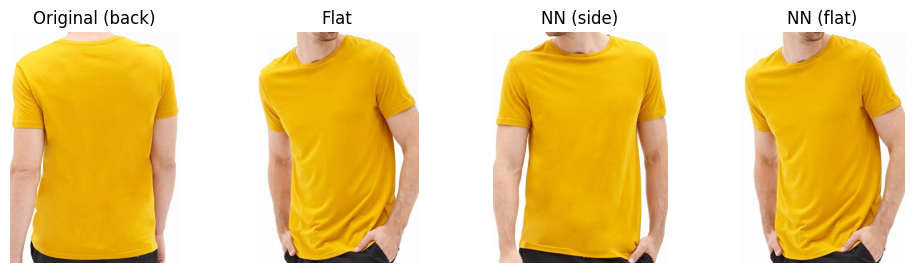

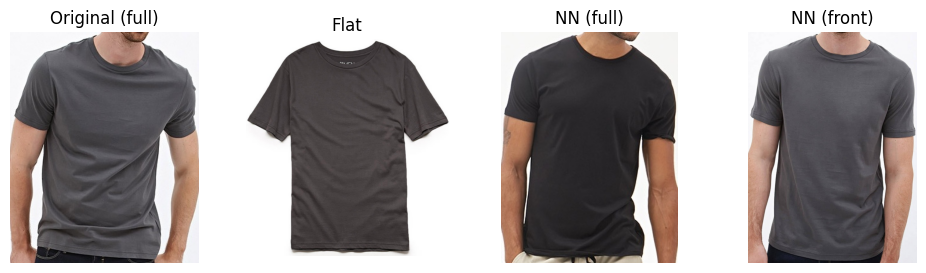

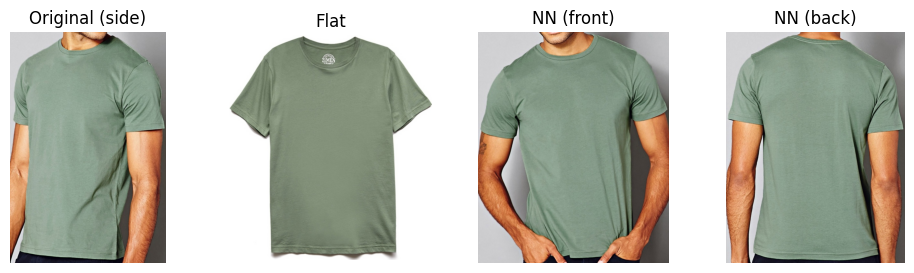

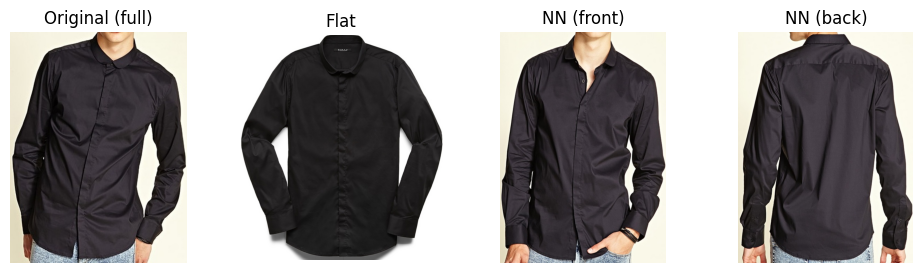

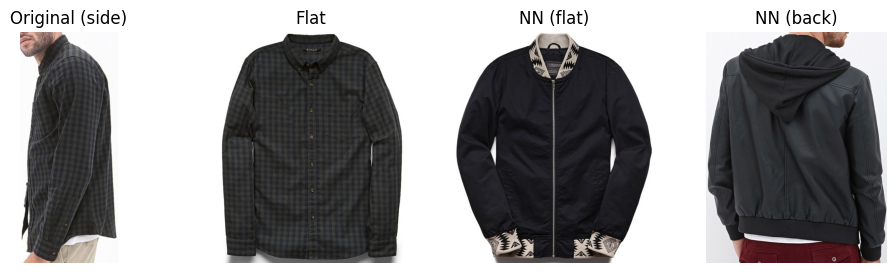

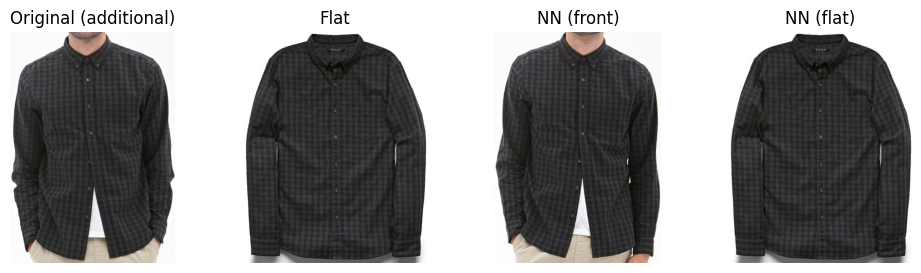

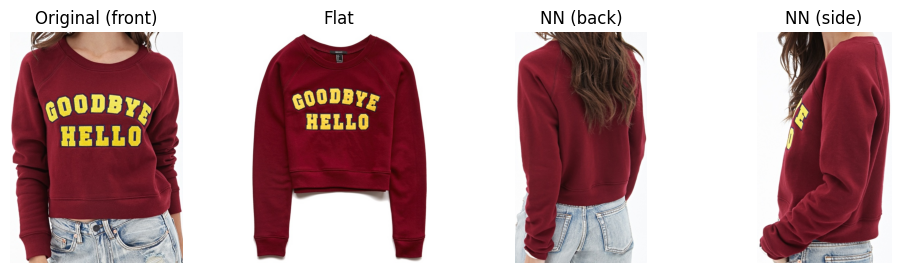

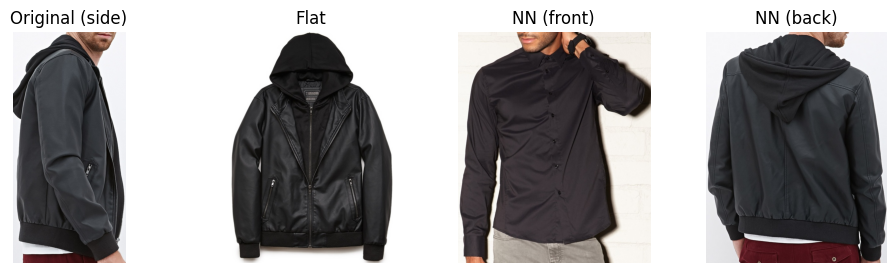

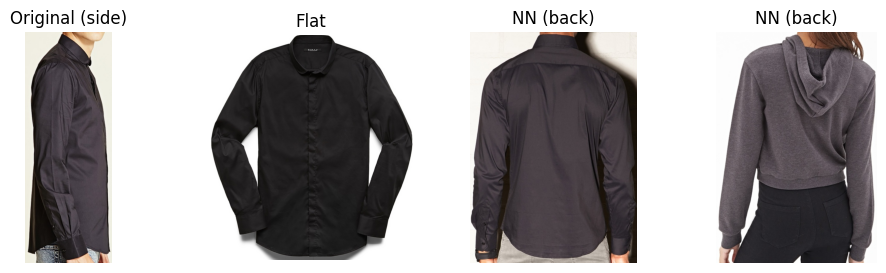

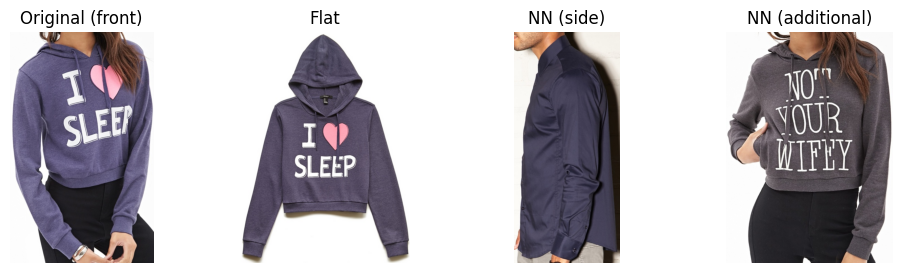

In [47]:
from PIL import Image
from sklearn.metrics.pairwise import cosine_distances

import matplotlib.pyplot as plt

def display_image_row(df, meta, encodings, idx, k=2, image_root='classification_dataset'):
    """
    Display: [original non-flat image | flat image | k nearest images by cosine similarity]
    """
    # Get info for the query image
    row = meta.iloc[idx]
    id_i, n1_i, pos_i = row['id'], row['n1'], row['pos']
    img_name = df.iloc[idx]['name']

    # Find the flat image for this (id, n1)
    flat_idx = meta[(meta['id'] == id_i) & (meta['n1'] == n1_i) & (meta['pos'] == 'flat')].index
    flat_img_name = None
    if len(flat_idx) > 0:
        flat_img_name = df.iloc[flat_idx[0]]['name']

    # Find k nearest neighbors (excluding self)
    cos_distances = cosine_distances([encodings[idx]], encodings)[0]
    neighbor_indices = np.argsort(cos_distances)[1:k+1]

    # Prepare image paths
    def get_img_path(name):
        # Try train_crop, then val_crop
        for set_type in ['train', 'val']:
            path = os.path.join(image_root, f"{set_type}_crop", name.replace('.jpg', '_crop.jpg'))
            if os.path.exists(path):
                return path
        return None

    images = []
    titles = []

    # Original non-flat image
    orig_path = get_img_path(img_name)
    if orig_path:
        images.append(Image.open(orig_path))
        titles.append(f"Original ({pos_i})")
    else:
        images.append(None)
        titles.append("Original (not found)")

    # Flat image
    if flat_img_name:
        flat_path = get_img_path(flat_img_name)
        if flat_path:
            images.append(Image.open(flat_path))
            titles.append("Flat")
        else:
            images.append(None)
            titles.append("Flat (not found)")
    else:
        images.append(None)
        titles.append("Flat (not found)")

    # k nearest neighbors
    for n_idx in neighbor_indices:
        n_img_name = df.iloc[n_idx]['name']
        n_pos = meta.iloc[n_idx]['pos']
        n_path = get_img_path(n_img_name)
        if n_path:
            images.append(Image.open(n_path))
            titles.append(f"NN ({n_pos})")
        else:
            images.append(None)
            titles.append(f"NN ({n_pos}) (not found)")

    # Plot
    plt.figure(figsize=(3 * (2 + k), 3))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        if img:
            plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

# Example: show for the first 3 non-flat images
# Randomly sample 10 non-flat indices
non_flat_indices = meta[meta['pos'] != 'flat'].sample(n=10, random_state=42).index
for idx in non_flat_indices:
    display_image_row(couples_with_flat_other_pos_sorted, meta, encodings, idx, k=2)

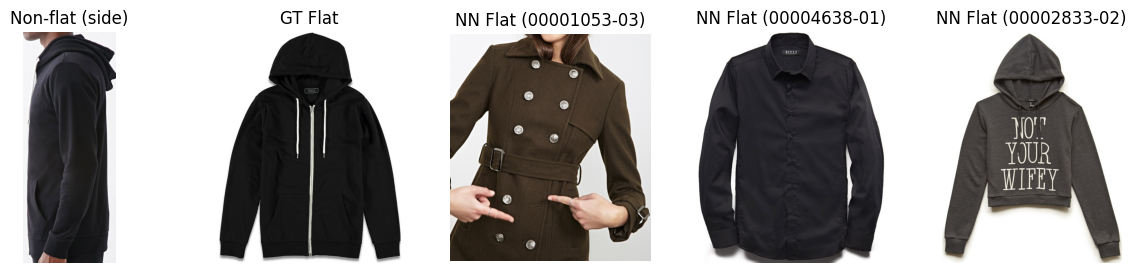

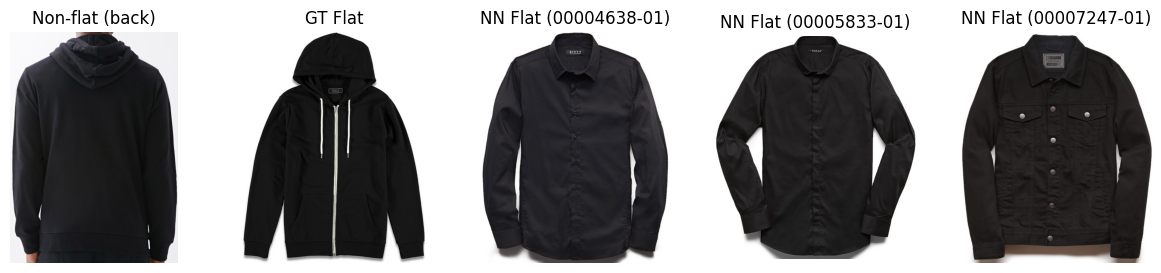

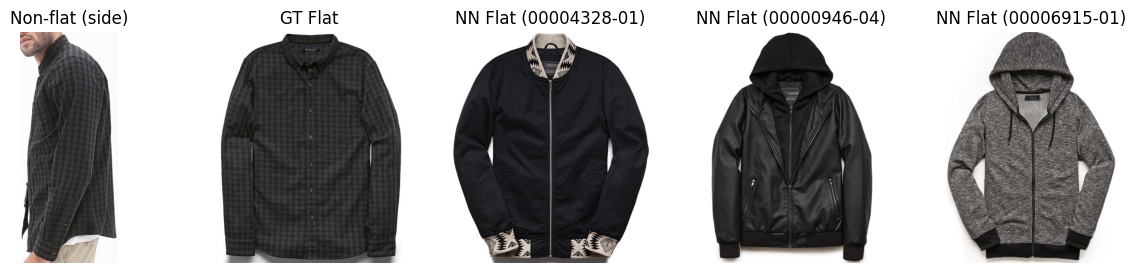

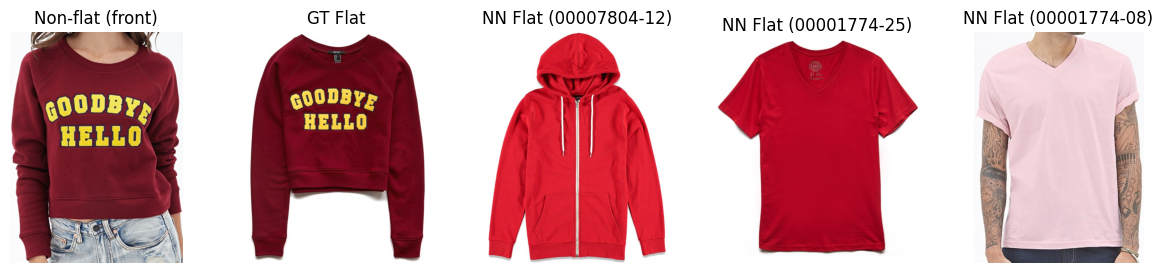

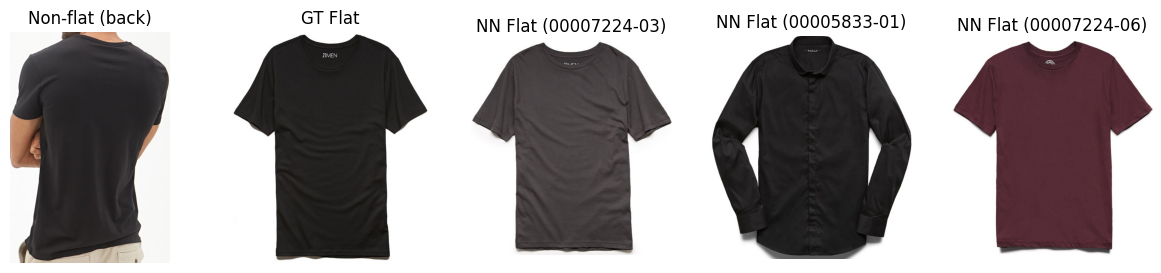

In [49]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

# Get indices for non-flat and flat images
non_flat_indices = meta[meta['pos'] != 'flat'].index
flat_indices = meta[meta['pos'] == 'flat'].index

# Compute cosine distances between all non-flat and all flat encodings
non_flat_encodings = encodings[non_flat_indices]
flat_encodings = encodings[flat_indices]
cos_dist_nf_flat = cosine_distances(non_flat_encodings, flat_encodings)

def get_img_path(name, image_root='classification_dataset'):
    for set_type in ['train', 'val']:
        path = os.path.join(image_root, f"{set_type}_crop", name.replace('.jpg', '_crop.jpg'))
        if os.path.exists(path):
            return path
    return None

def display_flat_neighbors(idx, k=2):
    # idx: index in meta/df for a non-flat image
    row = meta.iloc[idx]
    id_i, n1_i = row['id'], row['n1']
    img_name = couples_with_flat_other_pos_sorted.iloc[idx]['name']

    # Find ground truth flat image for this (id, n1)
    gt_flat_idx = flat_indices[(meta.iloc[flat_indices]['id'] == id_i) & (meta.iloc[flat_indices]['n1'] == n1_i)]
    gt_flat_img_name = None
    if len(gt_flat_idx) > 0:
        gt_flat_img_name = couples_with_flat_other_pos_sorted.iloc[gt_flat_idx[0]]['name']

    # Find k nearest flat images (excluding ground truth if present)
    nf_idx_in_nf = np.where(non_flat_indices == idx)[0][0]
    dists = cos_dist_nf_flat[nf_idx_in_nf]
    # Exclude ground truth flat index if present
    exclude = []
    if len(gt_flat_idx) > 0:
        gt_flat_idx_in_flat = np.where(flat_indices == gt_flat_idx[0])[0][0]
        exclude.append(gt_flat_idx_in_flat)
    nearest_flat_indices = [i for i in np.argsort(dists) if i not in exclude][:k]

    # Prepare images and titles
    images = []
    titles = []

    # Non-flat image
    orig_path = get_img_path(img_name)
    images.append(Image.open(orig_path) if orig_path else None)
    titles.append(f"Non-flat ({row['pos']})")

    # Ground truth flat image
    if gt_flat_img_name:
        gt_flat_path = get_img_path(gt_flat_img_name)
        images.append(Image.open(gt_flat_path) if gt_flat_path else None)
        titles.append("GT Flat")
    else:
        images.append(None)
        titles.append("GT Flat (not found)")

    # k nearest flat images
    for n_idx in nearest_flat_indices:
        flat_meta_idx = flat_indices[n_idx]
        n_img_name = couples_with_flat_other_pos_sorted.iloc[flat_meta_idx]['name']
        n_id = meta.iloc[flat_meta_idx]['id']
        n_n1 = meta.iloc[flat_meta_idx]['n1']
        n_path = get_img_path(n_img_name)
        images.append(Image.open(n_path) if n_path else None)
        titles.append(f"NN Flat ({n_id}-{n_n1})")

    # Plot
    plt.figure(figsize=(3 * (2 + k), 3))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        if img:
            plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

# Example: show for 5 random non-flat images
for idx in np.random.choice(non_flat_indices, size=5, replace=False):
    display_flat_neighbors(idx, k=3)

In [50]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

# Assume meta, encodings, and couples_with_flat_other_pos_sorted are already defined as above


# Get indices for non-flat and flat images
non_flat_indices = meta[meta['pos'] != 'flat'].index
flat_indices = meta[meta['pos'] == 'flat'].index

# Compute cosine distances between all non-flat and all flat encodings
non_flat_encodings = encodings[non_flat_indices]
flat_encodings = encodings[flat_indices]
cos_dist_nf_flat = cosine_distances(non_flat_encodings, flat_encodings)

# For each non-flat image, check if its true flat version is among the k closest flat images
ratios = {}
n_queries = len(non_flat_indices)
for k in range(1, 6):
    found = 0
    for i, idx in enumerate(non_flat_indices):
        row = meta.iloc[idx]
        id_i, n1_i = row['id'], row['n1']
        # Find ground truth flat index for this (id, n1)
        gt_flat_idx = flat_indices[(meta.iloc[flat_indices]['id'] == id_i) & (meta.iloc[flat_indices]['n1'] == n1_i)]
        if len(gt_flat_idx) == 0:
            continue  # No ground truth flat image for this query
        gt_flat_idx_in_flat = np.where(flat_indices == gt_flat_idx[0])[0][0]
        # Find k nearest flat images
        nearest_flat_indices = np.argsort(cos_dist_nf_flat[i])[:k]
        if gt_flat_idx_in_flat in nearest_flat_indices:
            found += 1
    ratios[k] = found / n_queries if n_queries > 0 else 0

print("Ratio of non-flat images with true flat version in top-k nearest flat images:")
for k in range(1, 6):
    print(f"Top-{k}: {ratios[k]:.4f} ({ratios[k]*100:.2f}%)")

Ratio of non-flat images with true flat version in top-k nearest flat images:
Top-1: 0.3736 (37.36%)
Top-2: 0.4828 (48.28%)
Top-3: 0.5690 (56.90%)
Top-4: 0.6379 (63.79%)
Top-5: 0.6724 (67.24%)


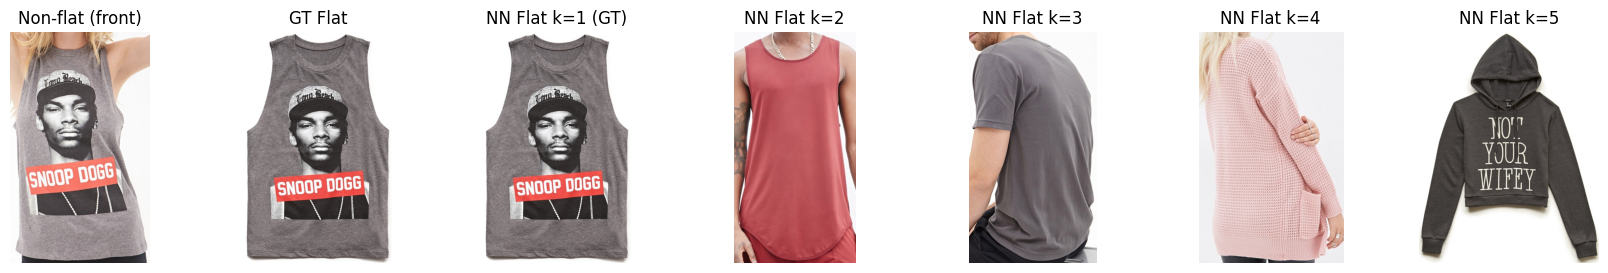

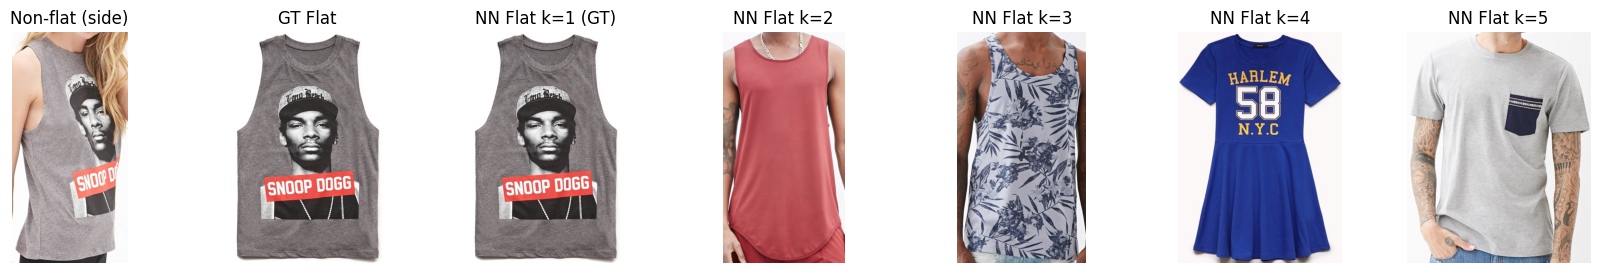

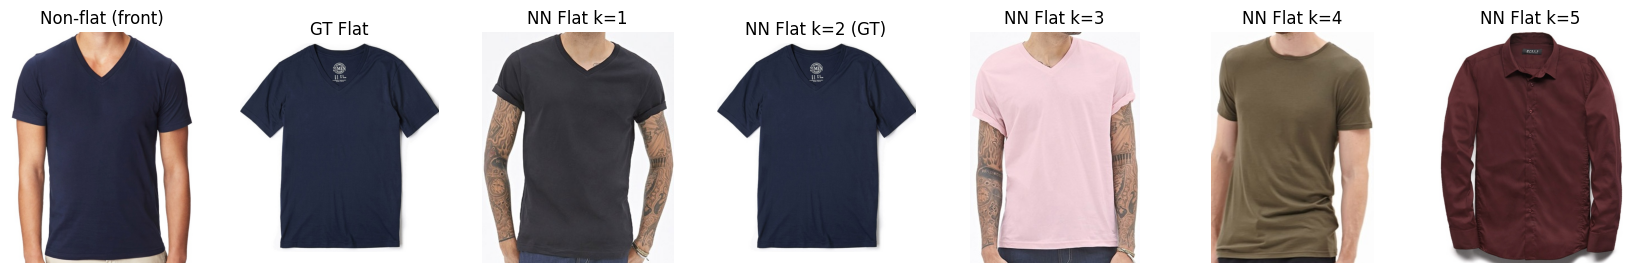

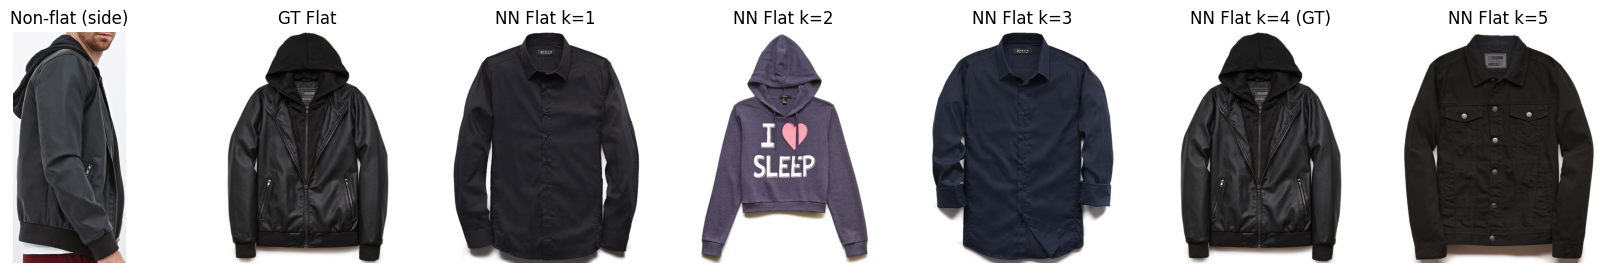

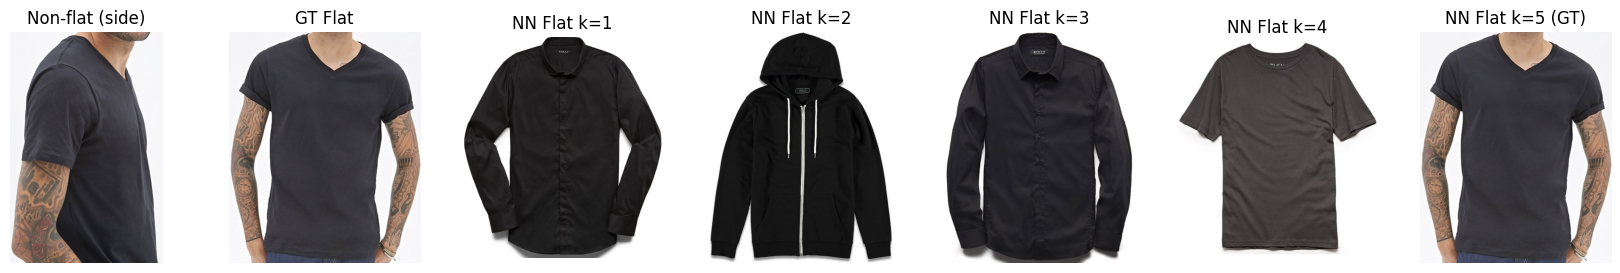

In [68]:
# Find indices for non-flat images where the ground truth flat is at k=1, k=2, k=4, or k=5 neighbor
# Use the cosine distance matrix and meta, flat_indices, non_flat_indices from previous cells

# Helper to get ground truth flat index in flat_indices for a given non-flat idx
def get_gt_flat_idx_in_flat(idx):
    row = meta.iloc[idx]
    id_i, n1_i = row['id'], row['n1']
    gt_flat_idx = flat_indices[(meta.iloc[flat_indices]['id'] == id_i) & (meta.iloc[flat_indices]['n1'] == n1_i)]
    if len(gt_flat_idx) == 0:
        return None
    return np.where(flat_indices == gt_flat_idx[0])[0][0]

# For each non-flat image, find the rank of the ground truth flat image among flat neighbors
gt_ranks = {}
for i, idx in enumerate(non_flat_indices):
    gt_flat_idx_in_flat = get_gt_flat_idx_in_flat(idx)
    if gt_flat_idx_in_flat is None:
        continue
    dists = cos_dist_nf_flat[i]
    sorted_indices = np.argsort(dists)
    rank = np.where(sorted_indices == gt_flat_idx_in_flat)[0][0]  # 0-based
    gt_ranks[idx] = rank + 1  # 1-based

# Find indices for required cases
k1_indices = [idx for idx, rank in gt_ranks.items() if rank == 1][:2]
k2_indices = [idx for idx, rank in gt_ranks.items() if rank == 2][:1]
k4_5_indices = [idx for idx, rank in gt_ranks.items() if rank in [4, 5]][:2]

selected_indices = k1_indices + k2_indices + k4_5_indices

def display_flat_neighbors_with_k(idx, max_k=5):
    row = meta.iloc[idx]
    id_i, n1_i = row['id'], row['n1']
    img_name = couples_with_flat_other_pos_sorted.iloc[idx]['name']

    gt_flat_idx = flat_indices[(meta.iloc[flat_indices]['id'] == id_i) & (meta.iloc[flat_indices]['n1'] == n1_i)]
    gt_flat_img_name = None
    if len(gt_flat_idx) > 0:
        gt_flat_img_name = couples_with_flat_other_pos_sorted.iloc[gt_flat_idx[0]]['name']

    nf_idx_in_nf = np.where(non_flat_indices == idx)[0][0]
    dists = cos_dist_nf_flat[nf_idx_in_nf]
    sorted_flat_indices = np.argsort(dists)[:max_k]

    images = []
    titles = []

    # Non-flat image
    orig_path = get_img_path(img_name)
    images.append(Image.open(orig_path) if orig_path else None)
    titles.append(f"Non-flat ({row['pos']})")

    # Ground truth flat image
    if gt_flat_img_name:
        gt_flat_path = get_img_path(gt_flat_img_name)
        images.append(Image.open(gt_flat_path) if gt_flat_path else None)
        titles.append("GT Flat")
    else:
        images.append(None)
        titles.append("GT Flat (not found)")

    # k nearest flat images
    for i, n_idx in enumerate(sorted_flat_indices):
        flat_meta_idx = flat_indices[n_idx]
        n_img_name = couples_with_flat_other_pos_sorted.iloc[flat_meta_idx]['name']
        n_id = meta.iloc[flat_meta_idx]['id']
        n_n1 = meta.iloc[flat_meta_idx]['n1']
        n_path = get_img_path(n_img_name)
        label = f"NN Flat k={i+1}"
        if gt_flat_img_name and n_img_name == gt_flat_img_name:
            label += " (GT)"
        images.append(Image.open(n_path) if n_path else None)
        titles.append(label)

    plt.figure(figsize=(3 * (2 + max_k), 3))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        if img:
            plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

# Display the selected images
for idx in selected_indices:
    display_flat_neighbors_with_k(idx, max_k=5)